In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Input
from tensorflow.keras.models import Model

In [33]:
tr_data = pd.read_csv('datasets/train_data.txt', sep=':::', names = ['id', 'movie_name', 'genre', 'description']).drop('id', axis=1)
ts_data = pd.read_csv('datasets/test_data_solution.txt', sep=':::', names = ['movie_name', 'genre', 'description'])

C:\Users\shrey\AppData\Local\Temp\ipykernel_65500\4199842564.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tr_data = pd.read_csv('datasets/train_data.txt', sep=':::', names = ['id', 'movie_name', 'genre', 'description']).drop('id', axis=1)
C:\Users\shrey\AppData\Local\Temp\ipykernel_65500\4199842564.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ts_data = pd.read_csv('datasets/test_data_solution.txt', sep=':::', names = ['movie_name', 'genre', 'description'])


In [3]:
data = tr_data.drop('genre', axis=1)  # will use test data latter on
data.isnull().sum()

movie_name     0
description    0
dtype: int64

In [4]:
y = tr_data['genre'].values
x = data['description'].values

In [5]:
def filter_data(d):
    wnl = WordNetLemmatizer()  # lemmatizing instead of stemming to get better results
    for i in range(len(d)):
        print('Sent: ', i)
        d[i] = d[i].lower()
        words = word_tokenize(x[i])
        words = [wnl.lemmatize(w) for w in words if w not in stopwords.words('english')]
        # dataset is huge, so will not be able to accomodate all the words in our vocabulary.
        # That's why removing stopwords as tehy are not that important
        if len(words) > 300:
            words = words[:300]  # limiting to 300 words
        d[i] = ' '.join(words)
    return d

In [6]:
new_x = filter_data(x)

Sent:  0
Sent:  1
Sent:  2
Sent:  3
Sent:  4
Sent:  5
Sent:  6
Sent:  7
Sent:  8
Sent:  9
Sent:  10
Sent:  11
Sent:  12
Sent:  13
Sent:  14
Sent:  15
Sent:  16
Sent:  17
Sent:  18
Sent:  19
Sent:  20
Sent:  21
Sent:  22
Sent:  23
Sent:  24
Sent:  25
Sent:  26
Sent:  27
Sent:  28
Sent:  29
Sent:  30
Sent:  31
Sent:  32
Sent:  33
Sent:  34
Sent:  35
Sent:  36
Sent:  37
Sent:  38
Sent:  39
Sent:  40
Sent:  41
Sent:  42
Sent:  43
Sent:  44
Sent:  45
Sent:  46
Sent:  47
Sent:  48
Sent:  49
Sent:  50
Sent:  51
Sent:  52
Sent:  53
Sent:  54
Sent:  55
Sent:  56
Sent:  57
Sent:  58
Sent:  59
Sent:  60
Sent:  61
Sent:  62
Sent:  63
Sent:  64
Sent:  65
Sent:  66
Sent:  67
Sent:  68
Sent:  69
Sent:  70
Sent:  71
Sent:  72
Sent:  73
Sent:  74
Sent:  75
Sent:  76
Sent:  77
Sent:  78
Sent:  79
Sent:  80
Sent:  81
Sent:  82
Sent:  83
Sent:  84
Sent:  85
Sent:  86
Sent:  87
Sent:  88
Sent:  89
Sent:  90
Sent:  91
Sent:  92
Sent:  93
Sent:  94
Sent:  95
Sent:  96
Sent:  97
Sent:  98
Sent:  99
Sent:  100

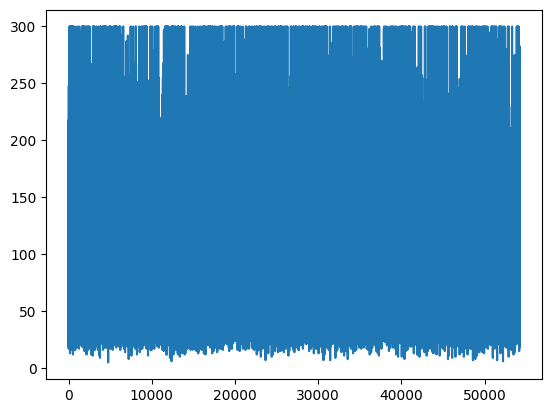

In [7]:
len_w = [len(i.split(' ')) for i in new_x]
plt.plot(len_w)
plt.show()
# so it can be observed that there are many of descriptions which are too large
# thats why we will limit the number of words in each description to 300 for efficiency

In [8]:
# pre-trained glove model will be used here to index the words in sentences and with embedding layer

with open('datasets/glove.6B/glove.6B.50d.txt', encoding='utf-8') as f:
    glove_words = set()
    word_to_vec_map = {}
    for line in f:
        line = line.strip().split()
        curr_word = line[0]
        glove_words.add(curr_word)
        word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
    word_to_index = {word: index for index, word in enumerate(word_to_vec_map.keys())}
    index_to_word = {index: word for index, word in enumerate(word_to_vec_map.keys())}

In [9]:
word_to_vec_map['the']

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01])

In [10]:
def sent_to_index(sent):
    sent = sent.lower()
    words = word_tokenize(sent)
    indexes = [word_to_index[w] for w in words if w in glove_words]
    return indexes
sent_to_index('listening conversation doctor parent , 10-year-old oscar learns nobody courage tell. .')

[6146, 4363, 2082, 3792, 1, 88077, 3991, 11196, 3291, 6721, 1361, 2, 2]

In [11]:
encoded_sent = []
for i in range(len(new_x)):
    encoded_sent.append(sent_to_index(new_x[i]))
    print('sent: ', i)

sent:  0
sent:  1
sent:  2
sent:  3
sent:  4
sent:  5
sent:  6
sent:  7
sent:  8
sent:  9
sent:  10
sent:  11
sent:  12
sent:  13
sent:  14
sent:  15
sent:  16
sent:  17
sent:  18
sent:  19
sent:  20
sent:  21
sent:  22
sent:  23
sent:  24
sent:  25
sent:  26
sent:  27
sent:  28
sent:  29
sent:  30
sent:  31
sent:  32
sent:  33
sent:  34
sent:  35
sent:  36
sent:  37
sent:  38
sent:  39
sent:  40
sent:  41
sent:  42
sent:  43
sent:  44
sent:  45
sent:  46
sent:  47
sent:  48
sent:  49
sent:  50
sent:  51
sent:  52
sent:  53
sent:  54
sent:  55
sent:  56
sent:  57
sent:  58
sent:  59
sent:  60
sent:  61
sent:  62
sent:  63
sent:  64
sent:  65
sent:  66
sent:  67
sent:  68
sent:  69
sent:  70
sent:  71
sent:  72
sent:  73
sent:  74
sent:  75
sent:  76
sent:  77
sent:  78
sent:  79
sent:  80
sent:  81
sent:  82
sent:  83
sent:  84
sent:  85
sent:  86
sent:  87
sent:  88
sent:  89
sent:  90
sent:  91
sent:  92
sent:  93
sent:  94
sent:  95
sent:  96
sent:  97
sent:  98
sent:  99
sent:  100

In [12]:
# now padding will be performed to make all the sentences of same length
maxlen = 300
padded_sent = pad_sequences(encoded_sent, maxlen=maxlen, padding='post')  # i will adjust the maxlen to some other value later on as per the resources
padded_sent.shape

(54214, 300)

In [13]:
# now lets create the pre-trained embedding layer
def pretrained_embedding_layer():
    emb_dim = word_to_vec_map['the'].shape[0]
    vocab_len = len(glove_words) + 1

    emb_matrix = np.zeros((vocab_len, emb_dim))

    for word, ind in word_to_index.items():
        emb_matrix[ind, :] = word_to_vec_map[word]
    
    emb_layer = Embedding(vocab_len, emb_dim)
    emb_layer.build((None,))
    emb_layer.set_weights([emb_matrix])

    return emb_layer
    

In [14]:
unique_genre = set(y)
genre_dict = {word:ind for ind, word in enumerate(unique_genre)}

len_y = len(unique_genre)
len_y

27

In [15]:
genre_dict

{' romance ': 0,
 ' short ': 1,
 ' biography ': 2,
 ' fantasy ': 3,
 ' musical ': 4,
 ' mystery ': 5,
 ' adventure ': 6,
 ' history ': 7,
 ' game-show ': 8,
 ' western ': 9,
 ' animation ': 10,
 ' crime ': 11,
 ' war ': 12,
 ' reality-tv ': 13,
 ' adult ': 14,
 ' documentary ': 15,
 ' action ': 16,
 ' drama ': 17,
 ' sport ': 18,
 ' music ': 19,
 ' horror ': 20,
 ' talk-show ': 21,
 ' thriller ': 22,
 ' sci-fi ': 23,
 ' family ': 24,
 ' news ': 25,
 ' comedy ': 26}

In [16]:
encoded_y = np.zeros((len(y), len_y))

for i in range(len(y)):
    encoded_y[i, genre_dict[y[i]]] = 1

In [17]:
encoded_y.shape

(54214, 27)

In [98]:
from tensorflow.keras.layers import Bidirectional
# model
embedding_layer = pretrained_embedding_layer()

inp_layer = Input(shape=(maxlen, ))
embeddings = embedding_layer(inp_layer)
X = Bidirectional(LSTM(64, return_sequences=True))(embeddings)
X = Dropout(0.7)(X)
X = Bidirectional(LSTM(64))(embeddings)
X = Dropout(0.7)(X)
X = Dense(len_y)(X)
X = Activation('softmax')(X)    # 0.9 and 20 epochs

model = Model(inp_layer, X)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 50)           20000050  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               58880     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 27)                3483      
_________________________________________________________________
activation_4 (Activation)    (None, 27)                0         
Total params: 20,062,413
Trainable params: 20,062,413
Non-trainable params: 0
_______________________________________________

In [99]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [92]:
padded_sent.shape, encoded_y.shape

((54214, 300), (54214, 27))

In [93]:
# we have more than 50k data to train, so we will take 4000 data for validation
X_train, X_val = padded_sent[:-4000], padded_sent[-4000:]
y_train, y_val = encoded_y[:-4000], encoded_y[-4000:]
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((50214, 300), (4000, 300), (50214, 27), (4000, 27))

In [100]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7, batch_size=128, shuffle=True)  # model is overfitting after 7-8 epochs, so we will stop here

Epoch 1/7
393/393 [==============================] - 23s 54ms/step - loss: 2.1571 - accuracy: 0.4017 - val_loss: 1.7982 - val_accuracy: 0.4782
Epoch 2/7
393/393 [==============================] - 21s 53ms/step - loss: 1.7900 - accuracy: 0.4972 - val_loss: 1.6424 - val_accuracy: 0.5265
Epoch 3/7
393/393 [==============================] - 21s 52ms/step - loss: 1.6091 - accuracy: 0.5503 - val_loss: 1.5581 - val_accuracy: 0.5465
Epoch 4/7
393/393 [==============================] - 20s 51ms/step - loss: 1.4682 - accuracy: 0.5938 - val_loss: 1.4904 - val_accuracy: 0.5665
Epoch 5/7
393/393 [==============================] - 20s 51ms/step - loss: 1.3136 - accuracy: 0.6398 - val_loss: 1.5137 - val_accuracy: 0.5707
Epoch 6/7
393/393 [==============================] - 20s 50ms/step - loss: 1.1724 - accuracy: 0.6815 - val_loss: 1.5404 - val_accuracy: 0.5665
Epoch 7/7
393/393 [==============================] - 20s 51ms/step - loss: 1.0138 - accuracy: 0.7277 - val_loss: 1.6668 - val_accuracy: 0.5565

# Train Accuracy: 72.77% and Validation Accuracy: 55.65%

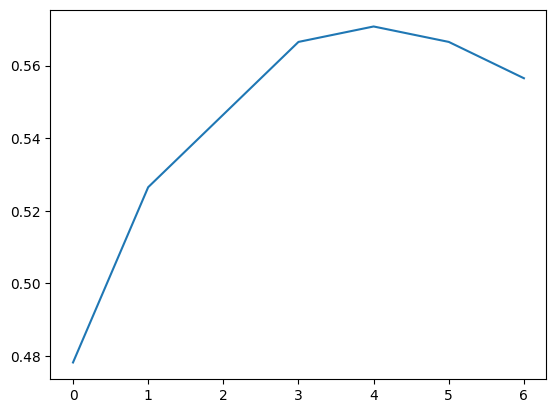

In [101]:
# ['loss', 'accuracy', 'val_loss', 'val_accuracy']  #20 epochs , 21
plt.plot(model.history.history['val_accuracy'])

In [76]:
test_data = ts_data.drop(['genre', 'movie_name'], axis=1).values.reshape((-1))
encoded_sent_test = []
for i in range(len(test_data)):
    encoded_sent_test.append(sent_to_index(test_data[i]))
    print('sent: ', i)

X_test = pad_sequences(encoded_sent_test, maxlen=maxlen, padding='post')

sent:  0
sent:  1
sent:  2
sent:  3
sent:  4
sent:  5
sent:  6
sent:  7
sent:  8
sent:  9
sent:  10
sent:  11
sent:  12
sent:  13
sent:  14
sent:  15
sent:  16
sent:  17
sent:  18
sent:  19
sent:  20
sent:  21
sent:  22
sent:  23
sent:  24
sent:  25
sent:  26
sent:  27
sent:  28
sent:  29
sent:  30
sent:  31
sent:  32
sent:  33
sent:  34
sent:  35
sent:  36
sent:  37
sent:  38
sent:  39
sent:  40
sent:  41
sent:  42
sent:  43
sent:  44
sent:  45
sent:  46
sent:  47
sent:  48
sent:  49
sent:  50
sent:  51
sent:  52
sent:  53
sent:  54
sent:  55
sent:  56
sent:  57
sent:  58
sent:  59
sent:  60
sent:  61
sent:  62
sent:  63
sent:  64
sent:  65
sent:  66
sent:  67
sent:  68
sent:  69
sent:  70
sent:  71
sent:  72
sent:  73
sent:  74
sent:  75
sent:  76
sent:  77
sent:  78
sent:  79
sent:  80
sent:  81
sent:  82
sent:  83
sent:  84
sent:  85
sent:  86
sent:  87
sent:  88
sent:  89
sent:  90
sent:  91
sent:  92
sent:  93
sent:  94
sent:  95
sent:  96
sent:  97
sent:  98
sent:  99
sent:  100

In [77]:
test_y = ts_data['genre'].values
encoded_y_test = np.zeros((len(test_y), len_y))
for i in range(len(test_y)):
    encoded_y_test[i, genre_dict[test_y[i]]] = 1
encoded_y_test.shape
y_test = encoded_y_test

In [78]:
X_test.shape, y_test.shape

((54200, 300), (54200, 27))

In [102]:
model.evaluate(X_test, y_test)

1694/1694 [==============================] - 22s 13ms/step - loss: 1.7855 - accuracy: 0.5228


[1.7854645252227783, 0.5228044390678406]

# Test Accuracy: 52.28%